In [1]:
"""
@author: albertigno
saucedo@imse-cnm.csic.es

"""

from DatasetLoader import *
import torch, time, os
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# check the type of device to be used
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

# this is where our SRNN model is defined
from srnn_model import*

True
cuda:0


## Global parameters

In [2]:
# parameters
batch_size = 200
learning_rate = 1e-4
time_window = 25
num_hidden = 512

## Loading train and test set

In [3]:
# load dataset
train_path = r'./../../datasets/nmnist/nmnist_train.mat'
test_path = r'./../../datasets/nmnist/nmnist_test.mat'
print("loading test set...")
test_set = DatasetLoader(test_path, win=time_window, device='cpu')
test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last=True)

print("loading training set...")
train_set = DatasetLoader(train_path, win=time_window, device=device)
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)

loading test set...
num sample: 10000
torch.Size([10000, 25, 2312]) torch.Size([10000, 10])
loading training set...
num sample: 60000
torch.Size([60000, 25, 2312]) torch.Size([60000, 10])


## Instantiation of the LSM

In [4]:
# instantiate the LSM
snn = RSNN_Model(num_hidden, time_window, batch_size, device)
snn.freeze_parameters()
snn.to(device)
modelname = 'nmnist_rnn_lsm_{}.t7'.format(num_hidden)
print(modelname)

torch.Size([512, 2312])
Frozen
torch.Size([512, 512])
Frozen
torch.Size([10, 512])
nmnist_rnn_lsm_512.t7


## Training configuration

In [5]:
# Training configuration

num_epochs = 10
criterion = nn.MSELoss()
def lr_scheduler(optimizer, epoch, init_lr=0.1, lr_decay_epoch=100):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""

    if epoch % lr_decay_epoch == 0 and epoch > 1:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.98

    return optimizer

optimizer = torch.optim.Adam(snn.parameters(), lr=learning_rate)

act_fun = ActFun.apply

## Weight visualization

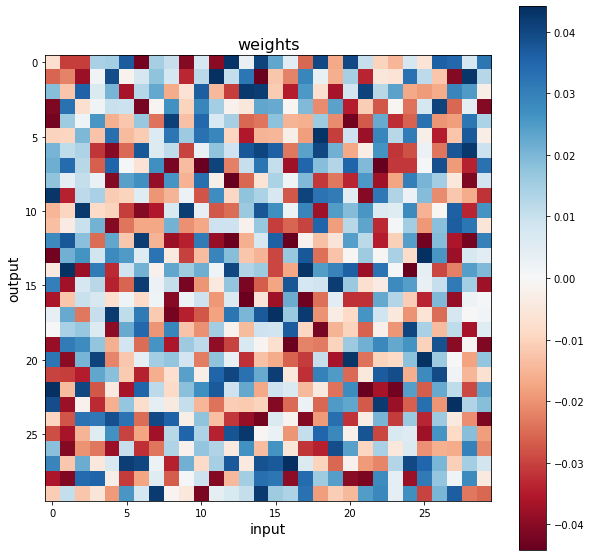

In [6]:
q = snn.plot_weights('hh', 'matrix', crop_size=30)

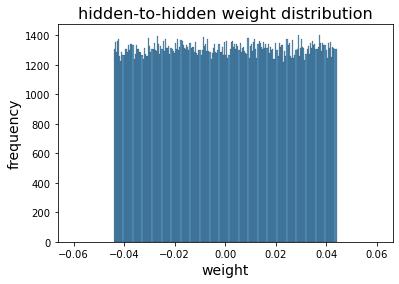

In [7]:
q = snn.plot_weights('hh', 'histogram')

## Training Loop

In [8]:
# training loop
taus_m = []
max_acc = 0
for epoch in range(num_epochs):
    print('Epoch [%d/%d]'  % (epoch + 1, num_epochs))
    start_time = time.time()
    snn.train_step(train_loader, optimizer=optimizer, criterion=nn.MSELoss(), num_samples = 60000)
    t =  time.time() - start_time
    print('Time elasped:', t)
    
    # adjust learning rate
    optimizer = snn.lr_scheduler(optimizer, lr_decay_epoch=1)
    
    # evaluate every 2 epochs
    if (epoch + 1) % 2 == 0:
        snn.test(test_loader, criterion=nn.MSELoss())
        if snn.acc[-1][1]>max_acc:
            print('Saving max acc model')
            snn.save_model(modelname)
            max_acc = snn.acc[-1][1]
                
with open('training_log', 'a') as logs:
    logs.write("\nFinished training {} epochs for {}, batch_size {}, time_per_epoch {} s".format(num_epochs, modelname, batch_size, t))       

Epoch [1/10]
Step [100/300], Loss: 8.64481
Step [200/300], Loss: 7.34182
Step [300/300], Loss: 6.59228
Time elasped: 10.311485052108765
Epoch [2/10]
Step [100/300], Loss: 6.09203
Step [200/300], Loss: 5.73702
Step [300/300], Loss: 5.46473
Time elasped: 9.314023971557617
Test Accuracy of the model on the test samples: 79.120
Saving max acc model
Epoch [3/10]
Step [100/300], Loss: 5.26469
Step [200/300], Loss: 5.09195
Step [300/300], Loss: 4.94974
Time elasped: 9.317009925842285
Epoch [4/10]
Step [100/300], Loss: 4.81728
Step [200/300], Loss: 4.73524
Step [300/300], Loss: 4.67173
Time elasped: 9.32043170928955
Test Accuracy of the model on the test samples: 82.600
Saving max acc model
Epoch [5/10]
Step [100/300], Loss: 4.58170
Step [200/300], Loss: 4.50754
Step [300/300], Loss: 4.42902
Time elasped: 9.2272789478302
Epoch [6/10]
Step [100/300], Loss: 4.38567
Step [200/300], Loss: 4.35670
Step [300/300], Loss: 4.28363
Time elasped: 9.111153364181519
Test Accuracy of the model on the test s

## Post-training weight visualization

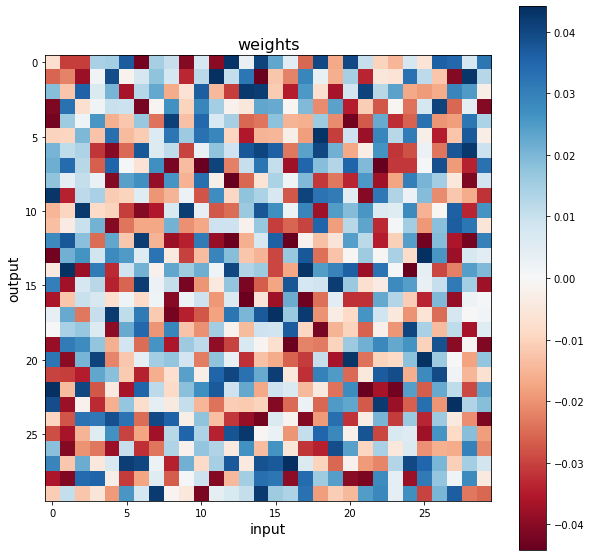

In [9]:
q2 = snn.plot_weights('hh', 'matrix', crop_size=30)

## Visualizing training and test loss

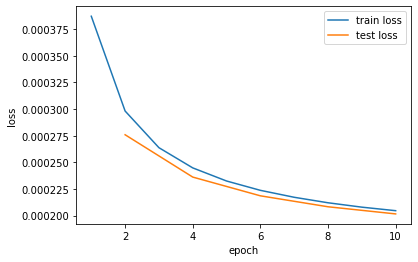

In [10]:
snn.load_model(modelname, batch_size=batch_size, device=device)
p = snn.plot_loss()

## Saving the weights to numpy

In [10]:
snn.save_to_numpy(modelname[:-2])

## Quantize weights

In [11]:
snn_q = RSNN_Model()
snn_q.load_model(modelname, batch_size=batch_size, device=device)
snn_q.quantize_weights(bits = 2)

## Visualize weight quantization

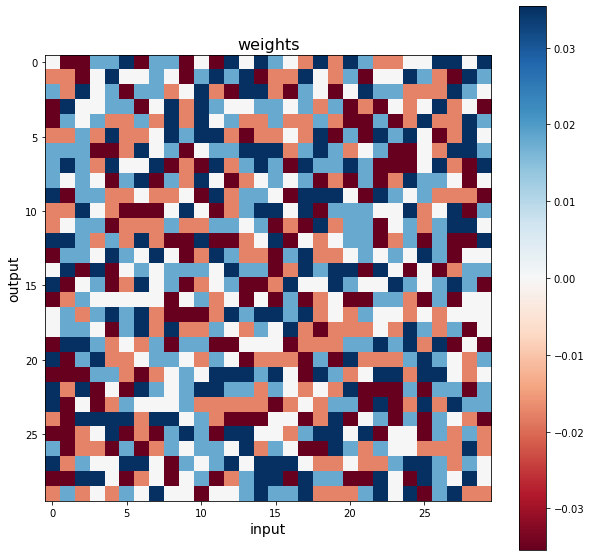

In [12]:
q3 = snn_q.plot_weights('hh', 'matrix', crop_size=30)

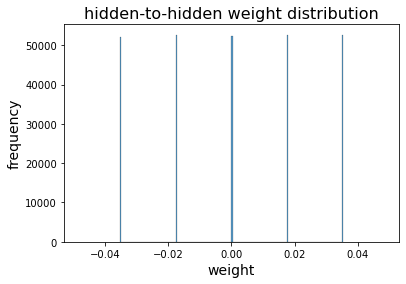

In [13]:
q3 = snn_q.plot_weights('hh', 'histogram')

## Evaluate performance of quantized LSM

In [14]:
snn.test(test_loader, criterion=nn.MSELoss())
snn_q.test(test_loader, criterion=nn.MSELoss())

Test Accuracy of the model on the test samples: 85.330
Test Accuracy of the model on the test samples: 84.210


## Saving the quantized weights to numpy 

snn_q.save_to_numpy(modelname[:-2]+'')m